# Optimization Via Exploration

Thesis entitled *The Metropolis-Hastings Algorithm: Inverse Problems, Model Calibration, and the TOMGRO Model*


Notebook done by **Carlos Nosa**. 




We are going to use the following packages:

In [1]:
using StatsPlots
using LinearAlgebra
using Random
using Statistics
using Distributions
using Plots
using LaTeXStrings

In [2]:
function MHRW(energia,np,p0,δ=0.5,iterations=10000)
    
    
    #Muestras del algorimo
    samples = zeros(np,iterations)
    #Punto de partida
    ## Se escoge el punto inicial obtenido de invertir el operador A
    samples[:,1] = p0
    
    #Probabilidades
    probabilities = zeros(iterations)
    probabilities[1] = energia(samples[:,1])
    
    #Tasa de aceptación
    rateAlpha = 0
    
    # Algoritmo Metrópolis-Hastings
    for i in 1:iterations-1
        
        #Estado actual
        Xᵢ = samples[:,i]
        #Estado propuesto
        X₊ = rand(MvNormal(Xᵢ,δ*I))
        
        #π(Estado actual → Estado propuesto)
        pXᵢX₊ = energia(X₊) * pdf(MvNormal(Xᵢ,δ*I),X₊)
        #π(Estado propuesto → Estado actual)
        pX₊Xᵢ = energia(Xᵢ) * pdf(MvNormal(X₊,δ*I),Xᵢ)
        #Tasa de aceptacion α
        alpha = min(1, pXᵢX₊/pX₊Xᵢ)
    
        #Aceptación o rechazo del estado propuesto
        u = rand()    
        if u < alpha 				#Aceptación
            samples[:,i+1] = X₊
            probabilities[i+1] = energia(X₊)
            rateAlpha += 1
        else 						#Rechazo
            samples[:,i+1] = Xᵢ
            probabilities[i+1] = energia(Xᵢ)
        end
    end
    rateAlpha /= (iterations-1)
    MAP = samples[:,findmax(probabilities)[2]]
    CM = [mean(row) for row in eachrow(samples)]
    return samples, probabilities, MAP, CM, rateAlpha
end

MHRW (generic function with 3 methods)

# Example 0

## Without using Bayesian inference

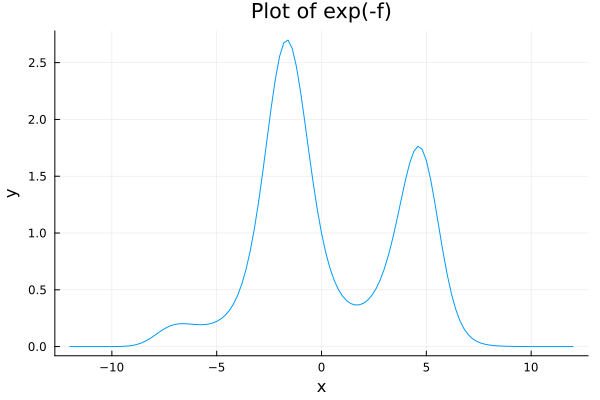

In [3]:
function energiaoptim(x)
    a = (3*x/10)^4 + 10*sin(π*3*x/10)
    return exp(-a/10) 
end
lim = 12
plot(-lim:0.2:lim,energiaoptim.(-lim:0.2:lim),label="",title="Plot of exp(-f)",xlabel="x",ylabel="y")

In [4]:
iterations = 10000
δ = 5
#Muestras del algorimo
samples = zeros(iterations)
#Punto de partida
## Se escoge el punto inicial obtenido de invertir el operador A
samples[1] = 20.0

#Probabilidades
probabilities = zeros(iterations)
probabilities[1] = energiaoptim(samples[1])

#Tasa de aceptación
rateAlpha = 0

# Algoritmo Metrópolis-Hastings
for i in 1:iterations-1
    
    #Estado actual
    Xᵢ = samples[i]
    #Estado propuesto
    X₊ = rand(Normal(Xᵢ,δ))
    
    #π(Estado actual → Estado propuesto)
    pXᵢX₊ = energiaoptim(X₊) * pdf(Normal(Xᵢ,δ),X₊)
    #π(Estado propuesto → Estado actual)
    pX₊Xᵢ = energiaoptim(Xᵢ) * pdf(Normal(X₊,δ),Xᵢ)
    #Tasa de aceptacion α
    alpha = min(1, pXᵢX₊/pX₊Xᵢ)

    #Aceptación o rechazo del estado propuesto
    u = rand()    
    if u < alpha 				#Aceptación
        samples[i+1] = X₊
        probabilities[i+1] = energiaoptim(X₊)
        rateAlpha += 1
    else 						#Rechazo
        samples[i+1] = Xᵢ
        probabilities[i+1] = energiaoptim(Xᵢ)
    end
end
rateAlpha /= (iterations-1)



0.4588458845884588

In [22]:
p1 = plot(log.(probabilities[1:10:end]), title="Log-density", label="",xlabel="Iterations",ylabel="Log-density")
p2 = plot(1:50:10000,samples[1:50:end],title="Markov chain",label="", xlabel="Iterations", ylabel="Sample",ylim=(-15,15))
p3 = plot(-lim:0.2:lim,[(3*x/10)^4 + 10*sin(π*3*x/10) for x in -lim:0.2:lim],label="", 
    title="Objective function",xlabel="x", ylabel="y",lw=2,xlim=(-15,15))
p4 = histogram(samples, normalize=true,label="",xlim=(-15,15), title="Histogram of samples",xlabel="Samples")

plot(p3,p1,p4,p2,layout=(2,2))
#savefig("5_OptExp_Example1a.png")

"C:\\Users\\carlo\\5_OptExp_Example1a.png"

## Using Bayesian inference

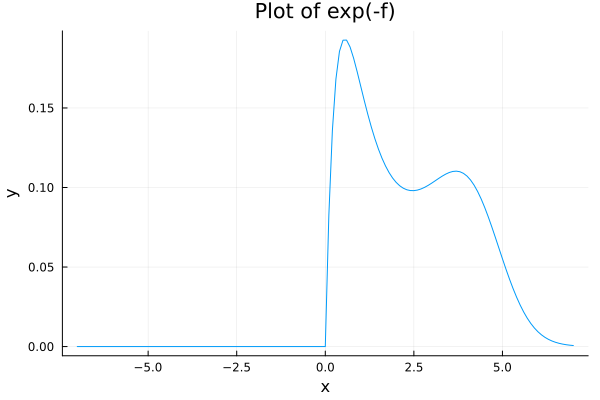

In [2]:
function energiaoptimbayesian(x)
    a = (3*x/10)^4 + 10*sin(π*3*x/10)
    if x>0
        prior = pdf(Gamma(2, 1), x)
    else
        prior = 0
    end
    return exp(-a/10) * prior
end
lim = 7
plot(-lim:0.1:lim,energiaoptimbayesian.(-lim:0.1:lim),label="",title="Plot of exp(-f)",xlabel="x",ylabel="y")

In [11]:
iterations = 20000
δ = 5
#Muestras del algorimo
samples = zeros(iterations)
#Punto de partida
## Se escoge el punto inicial obtenido de invertir el operador A
samples[1] = 20.0

#Probabilidades
probabilities = zeros(iterations)
probabilities[1] = energiaoptimbayesian(samples[1])

#Tasa de aceptación
rateAlpha = 0

# Algoritmo Metrópolis-Hastings
for i in 1:iterations-1
    
    #Estado actual
    Xᵢ = samples[i]
    #Estado propuesto
    X₊ = rand(Normal(Xᵢ,δ))
    
    #π(Estado actual → Estado propuesto)
    pXᵢX₊ = energiaoptimbayesian(X₊) * pdf(Normal(Xᵢ,δ),X₊)
    #π(Estado propuesto → Estado actual)
    pX₊Xᵢ = energiaoptimbayesian(Xᵢ) * pdf(Normal(X₊,δ),Xᵢ)
    #Tasa de aceptacion α
    if pX₊Xᵢ > 0
        alpha = min(1, pXᵢX₊/pX₊Xᵢ)
    else
        alpha = 0
    end

    #Aceptación o rechazo del estado propuesto
    u = rand()    
    if u < alpha 				#Aceptación
        samples[i+1] = X₊
        probabilities[i+1] = energiaoptimbayesian(X₊)
        rateAlpha += 1
    else 						#Rechazo
        samples[i+1] = Xᵢ
        probabilities[i+1] = energiaoptimbayesian(Xᵢ)
    end
end
rateAlpha /= (iterations-1)


0.33486674333716687

In [14]:
p1 = plot(log.(probabilities[1:10:end]), title="Log-density", label="",xlabel="Iterations",ylabel="Log-density")
p2 = plot(1:50:20000,samples[1:50:end],title="Markov chain",label="", xlabel="Iterations", ylabel="Sample",ylim=(-15,15))
p3 = plot(-15:0.2:15,[(3*x/10)^4 + 10*sin(π*3*x/10) for x in -15:0.2:15],label="", 
    title="Objective function",xlabel="x", ylabel="y",lw=2,xlim=(-15,15))
p4 = histogram(samples, normalize=true,label="",xlim=(-15,15), title="Histogram of samples",xlabel="Samples")

plot(p3,p1,p4,p2,layout=(2,2))
#savefig("5_OptExp_Example1b.png")

"C:\\Users\\carlo\\5_OptExp_Example1b.png"

# Example 1

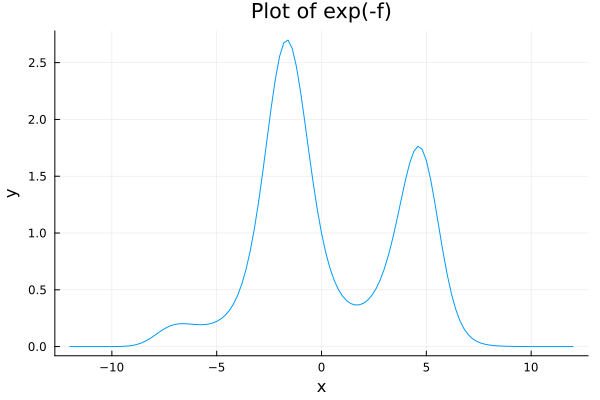

In [16]:
function energiaoptim(x)
    a = (3*x/10)^4 + 10*sin(π*3*x/10)
    return exp(-a/10) 
end
lim = 12
plot(-lim:0.2:lim,energiaoptim.(-lim:0.2:lim),label="",title="Plot of exp(-f)",xlabel="x",ylabel="y")

In [17]:
iterations = 50000
n  = 10
#Muestras del algorimo
samples = zeros(iterations)
#Punto de partida
## Se escoge el punto inicial obtenido de invertir el operador A
samples[1] = 30

#Probabilidades
probabilities = zeros(iterations)
probabilities[1] = energiaoptim(samples[1])

#Tasa de aceptación
rateAlpha = 0

# Algoritmo Metrópolis-Hastings
for i in 1:iterations-1
    
    #Estado actual
    x = samples[i]
    #Estado propuesto
    y = rand(Binomial(2*n,0.5)) + x - n
    
    #π(Estado actual → Estado propuesto)
    pxy = energiaoptim(y) * pdf(Binomial(2*n,0.5),y-x+n)
    #π(Estado propuesto → Estado actual)
    pyx = energiaoptim(x) * pdf(Binomial(2*n,0.5),x-y+n)
    #Tasa de aceptacion α
    if pyx > 0
        alpha = min(1, pxy/pyx)
    else
        alpha = 0
    end

    #Aceptación o rechazo del estado propuesto
    u = rand()    
    if u < alpha 				#Aceptación
        samples[i+1] = y
        probabilities[i+1] = energiaoptim(y)
        rateAlpha += 1
    else 						#Rechazo
        samples[i+1] = x
        probabilities[i+1] = energiaoptim(x)
    end
end
rateAlpha /= (iterations-1)

0.622072441448829

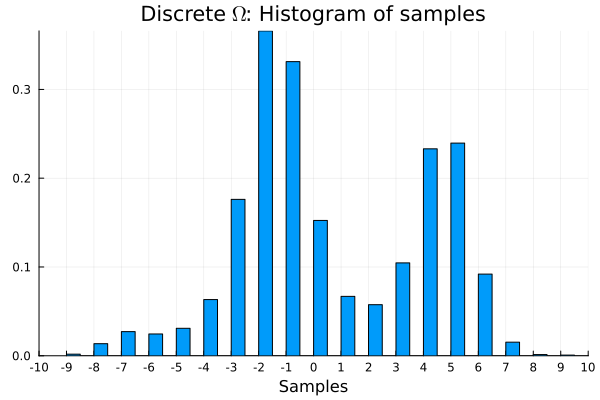

In [26]:
histogram(samples, normalize=true,label="",xlim=(-10,10), title=L"Discrete $\Omega$: Histogram of samples",xlabel="Samples",bins=100,
xticks=(-10:1:10, -10:1:10))
#savefig("5_OptExp_Example1c.png")

# Example 2

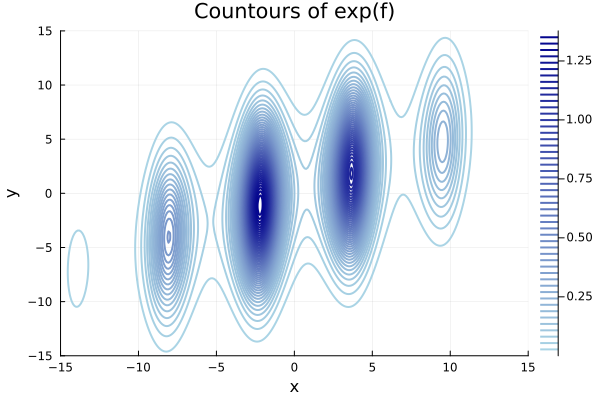

In [3]:
function energiaoptim2(p)
    x = p[1]
    y = p[2]
    a = sin(π*x/3) + cos(π*x/3) + 0.025*(x^2+y^2-x*y)+1
    return exp(-a) 
end
ran = range(-15, 15, length=300)

contour(ran, ran, [energiaoptim2((i, j)) for j in ran, i in ran], levels=50, 
    linewidth=2, color=:blues,
    xlim=(-15,15),ylim=(-15,15),
    title="Countours of exp(f)",
    xlabel="x", ylabel="y")

In [15]:
samples0, probabilities0, MAP0, CM0, rateAlpha0 = MHRW(energiaoptim2,2,[-12.0,-12.0],1,30000)

([-12.0 -13.401187754884539 … -2.011358772168288 -1.8976718716038472; -12.0 -12.217441973843155 … -2.215597087005327 -2.285009398675633], [0.003697863716482929, 0.01445265074459517, 0.015200623355418124, 0.015200623355418124, 0.015200623355418124, 0.017386744257331926, 0.00956018340790892, 0.00956018340790892, 0.006298009493979387, 0.002687332359071132  …  0.6374825207179279, 0.6371845697104943, 0.850756243635393, 1.1216188860255534, 1.2003778246818448, 1.2003778246818448, 1.2003778246818448, 0.26146592579096034, 1.294119632607337, 1.2298434224317645], [-2.2000401550872146, -1.151546612051013], [-0.7688650589183433, -0.9579050300200288], 0.6897563252108404)

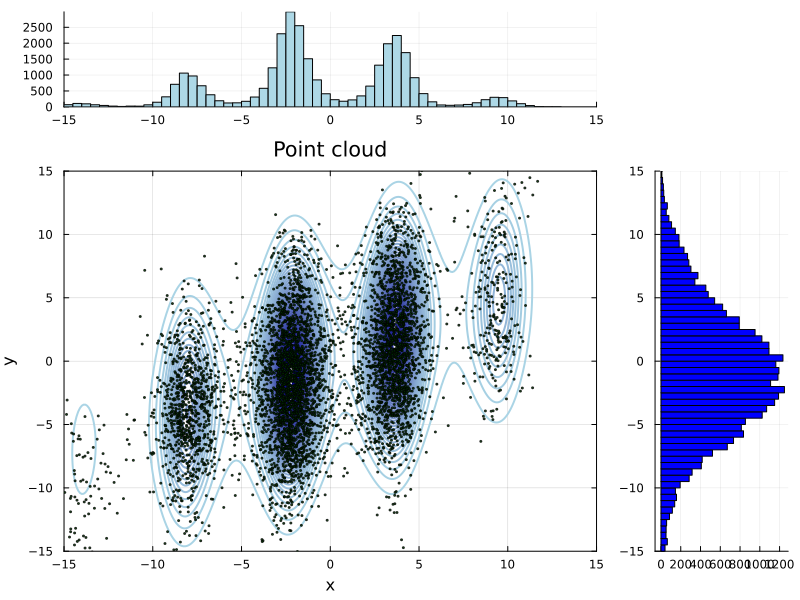

In [21]:
xhist = samples0[1, :]
yhist = samples0[2, :]
sxy = contour(ran, ran, [energiaoptim2((i, j)) for j in ran, i in ran], 
    levels=50, linewidth=2, color=:blues,xlim=(-15,15),ylim=(-15,15))

sxy = scatter!(xhist[1:5:end], yhist[1:5:end], markersize=1, title="Point cloud", color="green", alpha=0.8,
    xlabel="x", ylabel="y", border=:box,xlim=(-15,15),ylim=(-15,15),colorbar=false)
hx = histogram(xhist,color="lightblue",xlim=(-15,15))
hy = histogram(yhist, orientation=:horizontal,ylim=(-15,15),color="blue")
p0 = Plots.Plot()
cuadricula = grid(2,2, heights=(0.2,0.8), widths=(0.8,0.2))
PlotTotal = plot(hx, p0, sxy, hy, legend=:none, layout=cuadricula,size=(800,600))

PlotTotal
#savefig("5_OptExp_Example2.png")

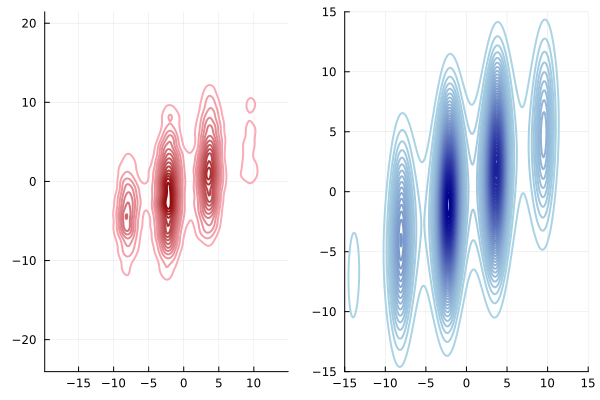

In [17]:
p1 = plot(StatsPlots.KernelDensity.kde((samples0[1,:],samples0[2,:])), colorbar=false,color=:reds,label="",ylabel="",lw=2)
p2 = contour(ran, ran, [energiaoptim2((i, j)) for j in ran, i in ran], 
    levels=50, linewidth=2, color=:blues,xlim=(-15,15),ylim=(-15,15),colorbar=false)
plot(p1,p2,layout=(1,2))